In [7]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
from src.preprocessing.load_data import *
from src.preprocessing.process_softchirp_features import find_outliers, choose_features
from src.data_representations.softchirp_features import compute_all_features
from src.data_representations.process_traces import clear_trace
from src.preprocessing.filters import filter_recs_metadata, filter_sounds_metadata_extended
from src.preprocessing.process_sounds_metadata import extend_sounds_metadata, compute_epochs
from src.visualization.plot_softchirps import plot
from src.util import delete_indexes
import src.visualization.plot_softchirps
from notebooks.analysis.plotting_config import ORDER, COLOR, EPOCHS # change plotting_config file to change colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import matplotlib
import matplotlib.cm as cm
%matplotlib inline

### Parameter selection

In [8]:
# specify paths, where data is stored
DATA_FOLDER_NAME = 'data/'
path_to_info = PATH_TO_PROJECT + DATA_FOLDER_NAME + '/rat_info.csv'
path_to_recordings_metadata = PATH_TO_PROJECT + DATA_FOLDER_NAME
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load, set filters here
colonies = 'all'
#colonies = 'all'
dates = 'all'
experiments = ['single rat softchirps']
stages = ['traced and checked',]

# specifies seconds to pixels ratio for spectrogram image
# uses librosa library which downsamples all audio files to 22050
sr = 22050
freq_mult = sr / 2  / 128

# specify outliers,soft chirp traces outside of these ranges are excluded from analysis  
boundaries = {'slope' : (0.01, .2), 
              'frequency' : (2000, 8000), 
              'duration' : (0.05, 10),
              'height' : (300, 6000)}

### Load data

In [9]:
# load info- and meta- data
info = load_info_file(path_to_info)
recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name, dtype={'ratids': str})

# filter what will be used (this is specified above)
mask = filter_recs_metadata(recs_metadata, dates, colonies, stages, experiments)
recs_to_analyse = recs_metadata[mask]

# load recording wavs, sound wavs and traces, create sounds metadata (master file)
recs_dict = load_recs_dict(recs_to_analyse)
traces, wavs, sounds_metadata = load_traces_wavs_and_metadata(recs_to_analyse, info, recs_dict)
sounds_metadata_extended = extend_sounds_metadata(sounds_metadata, info)
traces = [clear_trace(t, ) for t in traces]

# compute softchirp features
features, inds_skipped = compute_all_features(traces, wavs, freq_mult)
traces, wavs, sounds_metadata_extended = delete_indexes(inds_skipped, traces, wavs, sounds_metadata_extended)

# compute epochs 
sounds_metadata_extended = compute_epochs(sounds_metadata_extended, EPOCHS)

# remove outliers
outliers = find_outliers(features, boundaries )
features, sounds_metadata_extended = delete_indexes(outliers, features, sounds_metadata_extended)
print('Features could not be extracted from %d traces' % len(inds_skipped))
print('%d traces were deleted as outliers' %  len(outliers))
print('%d traces are left' % (len(sounds_metadata_extended)))

/home/gr1/tf2.1/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1890
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1449
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1805
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1842
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.p

Features could not be extracted from 0 traces
298 traces were deleted as outliers
7642 traces are left


In [10]:
save_excel = False
#save_path  = '' 
# creates master list of data as an excel file
all_data_table = pd.concat([sounds_metadata_extended, features], 1)
# save
if save_excel:
    all_data_table.to_excel('all_data!.xlsx')
all_data_table.head()

,rec,colony,date,ratids,experiment,s,e,cl,weight,sex,...,epoch,slope,frequency,pitch,amplitude,wiener_entropy,zero_crossings,duration,height,asymmetry
0,baratheon_21-06-19_9449_0000001.npy,baratheon,21-06-19,9449,single rat softchirps,102.016190,102.268980,softchirp,51.4,M,...,Q#1,0.018853,5116.793850,12334.823557,0.253675,0.253363,0.420344,0.176186,3445.312500,-1464.257812
1,baratheon_21-06-19_9449_0000001.npy,baratheon,21-06-19,9449,single rat softchirps,210.597959,210.836689,softchirp,51.4,M,...,Q#1,0.028884,5694.870887,27997.897017,0.485115,0.220619,0.450798,0.155364,3962.109375,-1894.921875
2,baratheon_21-06-19_9449_0000001.npy,baratheon,21-06-19,9449,single rat softchirps,73.869887,74.068526,softchirp,51.4,M,...,Q#1,0.053344,5966.205545,19570.867913,0.334804,0.096543,0.471689,0.122240,4048.242188,-1981.054688
3,baratheon_21-06-19_9449_0000001.npy,baratheon,21-06-19,9449,single rat softchirps,46.777460,46.986304,softchirp,51.4,M,...,Q#1,0.078588,5442.640537,15550.628697,0.298953,0.114862,0.452552,0.131494,3531.445312,-1291.992188
4,baratheon_21-06-19_9449_0000001.npy,baratheon,21-06-19,9449,single rat softchirps,54.701088,54.897778,softchirp,51.4,M,...,Q#1,0.055536,5881.270050,21046.556442,0.377478,0.186343,0.449389,0.154266,4392.773438,-1981.054688


In [11]:
from datetime import datetime
# It is possible here to compute date masks for each colony separately. If you don't want to use these masks, 
# set variable "separate_colonies_dates" to False in the cell below
func_to_dt = lambda x : datetime(*reversed(list(map(int, x.replace('-', '.').split('.')))))
dates_per_colony = {'baratheon' : ['24-03-19', '03-11-19'],
                    'martell':['24-03-19', '01-12-19'],
                    'targaryen':['24-03-19', '03-11-19'],
                    'dothrakib':['24-03-19', '03-11-19']}

separate_date_masks = np.zeros(len(sounds_metadata_extended), dtype='bool')

dates_transformed = sounds_metadata_extended['date'].apply(func_to_dt)
mask_dates_per_colony = np.ones(sounds_metadata_extended.shape[0], dtype='bool')
for col, (d_min, d_max) in dates_per_colony.items():
    d_min, d_max = func_to_dt(d_min), func_to_dt(d_max)
    col_mask_d = dates_transformed.apply(lambda x: d_min <= x <= d_max) & (sounds_metadata_extended['colony']
                                                                           == col)
    separate_date_masks = separate_date_masks | col_mask_d 

### Plotting

Keys:  ['rec', 'colony', 'date', 'ratids', 'experiment', 's', 'e', 'cl', 'weight', 'sex', 'rank', 'dob', 'age', 'bodylength', 'bodylength2', 'epoch']


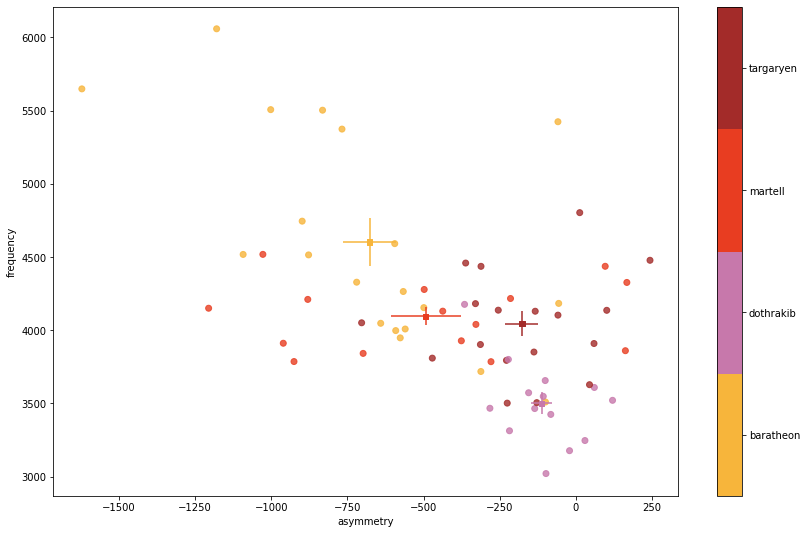

In [12]:

# specify what is ploted
print('Keys: ', list(sounds_metadata_extended.columns))
# specify filters
colonies = 'all'
weights = 'all'
dates = 'all'
sexes = 'all' # options: 'M', 'F', or 'all'
ages = 'all' # set range: (0, np.inf)
ranks = 'all' 
ratids =  'all'
excludeids = None # options: '1111', or None
bodylengths = 'all'# or set range
bodylengths2 = 'all' # or set range
sounds_per_rat = [20, 10000]
types = ['single'] # options for types: 'single', 'pairs', or 'all'

# how to plot
color_by = 'colony' #specfies color option in graph
#options = 'colony', 'age', 'weight'
features_to_plot = ['asymmetry', 'frequency',]
#features_to_plot = 'pca' #can make PCA ot tSNE plots of all features
perplexity = 50 #only required for tSNE

group_by_rat = True # plots mean values for each animal
plot_color_mean = True # plots mean for color_by grouping (i.e. colony)
group_color_column = False
plot_ellipses = False # plots ellipses representing 95% confidence intervals


order = ORDER[color_by]
color_dict = COLOR[color_by]


mask =  filter_sounds_metadata_extended(sounds_metadata_extended, ratids, excludeids, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
features_masked = features[mask]
sounds_metadata_masked = sounds_metadata_extended[mask]
y = sounds_metadata_masked[color_by]


plot(features_masked, y, sounds_metadata_masked, features_to_plot, perplexity,
     group_by_rat, group_color_column, plot_ellipses, plot_color_mean,
     color_dict, order, sizes_factor=32)